In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fsmodels import SklMultiExpFrequencyScan

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# sklearn-compatible class

https://scikit-learn.org/stable/developers/develop.html

https://scikit-learn.org/stable/glossary.html#glossary

In [2]:
frequency_powers = np.linspace(0, 3.5, 1000)
frequency_powers = tf.Variable(frequency_powers, dtype='float64').numpy()

In [3]:
fs = SklMultiExpFrequencyScan(n_exps=3, filling_pulse=20*10**-6)

fs.exps_params_ = [[-1.0, 3.5],
                  [-2.3, 3.0],
                  [-3.5, 2.5]]

experimental_dlts = fs.predict(frequency_powers) 
experimental_dlts += np.random.normal(loc=0, scale=0.2, size=experimental_dlts.shape[0])

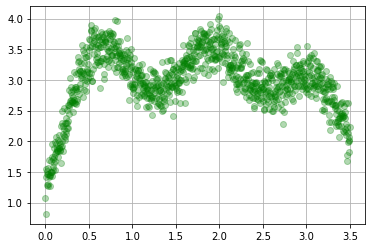

In [4]:
plt.plot(frequency_powers, experimental_dlts, 'og', alpha=0.3)
plt.grid()
plt.show()

In [5]:
n_exps = 3

fs = SklMultiExpFrequencyScan(n_exps=n_exps, 
                           filling_pulse=2*10**-5,
                           n_iters=200,
                           stop_val=10**-5,
                           verbose=False
                          )

fs.fit(X=frequency_powers, y=experimental_dlts)

SklMultiExpFrequencyScan(filling_pulse=2e-05, n_exps=3, n_iters=200,
                         stop_val=1e-05)

In [6]:
fit_results = fs.fit_results_
fit_results

,n_exps,filling_pulse,loss,time_constant_power_0,amplitude_0,time_constant_power_1,amplitude_1,time_constant_power_2,amplitude_2
0,3,0.00002,3.774122,-2.628190,1.000000,-1.223558,1.000000,-1.993856,1.000000
1,3,0.00002,3.296876,-2.637128,1.124603,-1.200788,1.139476,-1.992051,1.119803
2,3,0.00002,2.897071,-2.653972,1.237945,-1.172803,1.267606,-1.990461,1.226227
3,3,0.00002,2.55698,-2.677477,1.341681,-1.143004,1.386010,-1.988822,1.321647
4,3,0.00002,2.264563,-2.706080,1.437226,-1.114586,1.495938,-1.986881,1.408082
...,...,...,...,...,...,...,...,...,...
141,3,0.00002,0.043123,-3.503748,2.485428,-0.997432,3.509513,-2.305802,2.974748
142,3,0.00002,0.043112,-3.503921,2.484678,-0.997448,3.509818,-2.305964,2.975384
143,3,0.00002,0.043102,-3.504090,2.483942,-0.997463,3.510113,-2.306123,2.976006
144,3,0.00002,0.043091,-3.504254,2.483220,-0.997478,3.510397,-2.306277,2.976614


In [7]:
fs.exps_params_

array([[-3.50457045,  2.48182037],
       [-0.99750557,  3.51093707],
       [-2.30657449,  2.97779044]])

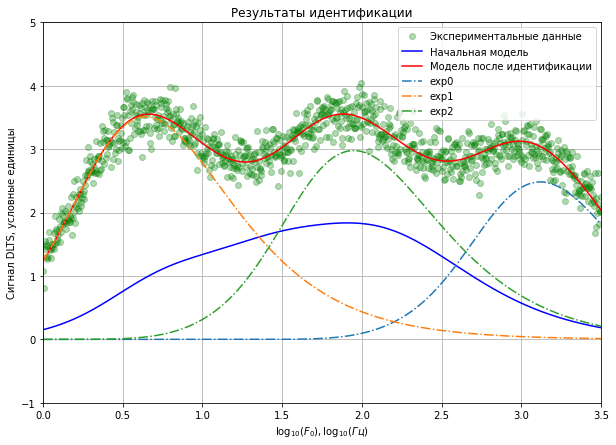

In [8]:
def plot_ident_res(frequency_powers,
                   experimental_dlts, 
                   fit_results
                  ):
    
    indices = frequency_powers.argsort()
    frequency_powers = frequency_powers[indices]
    experimental_dlts = experimental_dlts[indices]
    
    n_exps=fit_results.loc[0, 'n_exps']
    
    init_params = fit_results.iloc[0, :]
    init_params = [[init_params[f'time_constant_power_{i}'], init_params[f'amplitude_{i}']] for i in range(n_exps)]
    
    fs = SklMultiExpFrequencyScan(n_exps=n_exps, filling_pulse = fit_results.filling_pulse[0])
    fs.exps_params_ = init_params
    
    initial_model = fs.predict(frequency_powers)
    
    
    final_params = fit_results.iloc[-1, :]
    final_params = [[final_params[f'time_constant_power_{i}'], final_params[f'amplitude_{i}']] for i in range(n_exps)]
    
    fs.exps_params_=final_params
    final_model = fs.predict(frequency_powers)
    

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    ax.plot(frequency_powers, experimental_dlts, 'og', alpha=0.3, label='Экспериментальные данные')

    ax.plot(frequency_powers, initial_model, '-b', label='Начальная модель')

    ax.plot(frequency_powers, final_model, '-r', label='Модель после идентификации')

    for i, scan in enumerate(fs._fs_list):
        plt.plot(frequency_powers, scan(frequency_powers), '-.', label=f'exp{i}')

    ax.legend()
    ax.grid()
    ax.set_xlim([0, 3.5])
    ylim = ax.get_ylim()
    ylim = [np.floor(ylim[0]), np.ceil(ylim[1])]
    ax.set_ylim(ylim)
    
    ax.set_title('Результаты идентификации')
    ax.set_xlabel(r'$\log_{10}(F_0), \log_{10}(Гц)$')
    ax.set_ylabel('Сигнал DLTS, условные единицы')
    
    return fig, ax



fig, ax = plot_ident_res(frequency_powers,
                         experimental_dlts, 
                         fit_results
                        )

plt.show()

In [9]:
fs.get_params()

{'filling_pulse': 2e-05,
 'learning_rate': 0.1,
 'n_exps': 3,
 'n_iters': 200,
 'stop_val': 1e-05,
 'verbose': False}

In [10]:
fs.set_params(n_exps=4)

SklMultiExpFrequencyScan(filling_pulse=2e-05, n_exps=4, n_iters=200,
                         stop_val=1e-05)

In [11]:
fs.get_params()

{'filling_pulse': 2e-05,
 'learning_rate': 0.1,
 'n_exps': 4,
 'n_iters': 200,
 'stop_val': 1e-05,
 'verbose': False}

In [12]:
fs.score(X=frequency_powers, y=experimental_dlts)

0.8274760958357457

In [13]:
fs.predict(X=frequency_powers)

array([1.23491562, 1.24901784, 1.26321366, 1.27750239, 1.29188332,
       1.30635571, 1.32091878, 1.33557169, 1.3503136 , 1.36514361,
       1.38006078, 1.39506416, 1.41015273, 1.42532545, 1.44058123,
       1.45591896, 1.47133748, 1.48683559, 1.50241205, 1.51806559,
       1.5337949 , 1.54959862, 1.56547537, 1.58142371, 1.59744218,
       1.61352927, 1.62968344, 1.64590311, 1.66218665, 1.67853241,
       1.69493869, 1.71140376, 1.72792585, 1.74450315, 1.76113382,
       1.77781599, 1.79454773, 1.8113271 , 1.82815212, 1.84502076,
       1.86193097, 1.87888067, 1.89586775, 1.91289004, 1.92994538,
       1.94703155, 1.9641463 , 1.98128737, 1.99845245, 2.01563922,
       2.03284532, 2.05006838, 2.06730597, 2.08455568, 2.10181505,
       2.11908159, 2.13635281, 2.15362619, 2.17089918, 2.18816922,
       2.20543373, 2.22269012, 2.23993577, 2.25716805, 2.27438431,
       2.29158192, 2.30875818, 2.32591043, 2.34303597, 2.36013211,
       2.37719614, 2.39422535, 2.41121701, 2.42816841, 2.44507

# K-fold Cross-Validation and hyperparameter tuning

In [14]:
X_train, X_test, y_train, y_test = train_test_split(frequency_powers, experimental_dlts, test_size=0.2)

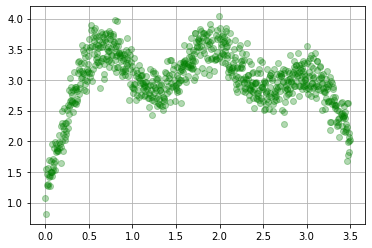

In [15]:
plt.plot(X_train, y_train, 'og', alpha=0.3)
plt.grid()
plt.show()

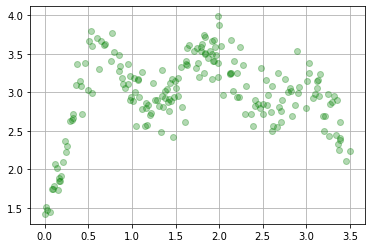

In [16]:
plt.plot(X_test, y_test, 'og', alpha=0.3)
plt.grid()
plt.show()

In [17]:
fs = SklMultiExpFrequencyScan(n_exps=2,
            filling_pulse=2*10**-5,
            n_iters=200,
            stop_val=10**-5,
            verbose=False
           )

fs.fit(X=X_train, y=y_train)

SklMultiExpFrequencyScan(filling_pulse=2e-05, n_exps=2, n_iters=200,
                         stop_val=1e-05)

In [18]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

scores = cross_val_score(fs, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

display_scores(np.sqrt(-scores))

Scores: [0.75944692 0.89137038 0.77837442 0.82180702 0.78248974 0.83246825
 0.8537173  0.88291787 0.73316997 0.73797592]
Mean: 0.8073737785534304
Standard deviation: 0.05461459630322497


In [19]:
fs.fit_results_

,n_exps,filling_pulse,loss,time_constant_power_0,amplitude_0,time_constant_power_1,amplitude_1
0,2,0.00002,5.502694,-1.670409,1.000000,-1.934890,1.000000
1,2,0.00002,5.133858,-1.640067,1.136175,-1.956083,1.135020
2,2,0.00002,4.802359,-1.597558,1.261076,-1.988424,1.258579
3,2,0.00002,4.478738,-1.539745,1.377208,-2.035437,1.373116
4,2,0.00002,4.134362,-1.465147,1.487670,-2.099581,1.481698
...,...,...,...,...,...,...,...
96,2,0.00002,0.648279,-1.135766,3.950941,-2.787649,3.707515
97,2,0.00002,0.648267,-1.135792,3.951999,-2.787779,3.707938
98,2,0.00002,0.648255,-1.135817,3.953005,-2.787903,3.708332
99,2,0.00002,0.648245,-1.135842,3.953963,-2.788021,3.708698


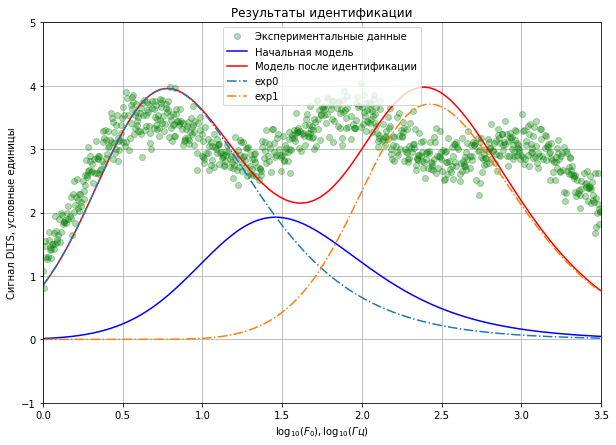

In [20]:
fit_results = fs.fit_results_

fig, ax = plot_ident_res(X_train,
                         y_train, 
                         fit_results
                        )

plt.show()

In [21]:
fs = SklMultiExpFrequencyScan(n_exps=5,
            filling_pulse=2*10**-5,
            n_iters=200,
            stop_val=10**-5,
            verbose=False
           )

fs.fit(X=X_train, y=y_train)

scores = cross_val_score(fs, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

display_scores(np.sqrt(-scores))

Scores: [0.21841912 0.2136901  0.19207205 0.21931065 0.22511251 0.25542882
 0.19359593 0.18791744 0.23540016 0.22638423]
Mean: 0.21673310008598579
Standard deviation: 0.02000440285414856


In [22]:
grid_search = GridSearchCV(fs, {'n_exps':[2,3,4,5]}, cv=5, scoring='neg_mean_squared_error', 
                           return_train_score=True, n_jobs=-1)

In [23]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=SklMultiExpFrequencyScan(filling_pulse=2e-05, n_exps=5,
                                                n_iters=200, stop_val=1e-05),
             n_jobs=-1, param_grid={'n_exps': [2, 3, 4, 5]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [24]:
grid_search.best_params_

{'n_exps': 3}

In [25]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.8104368822853897 {'n_exps': 2}
0.20766737934213647 {'n_exps': 3}
0.2221425658354444 {'n_exps': 4}
0.21888546372127665 {'n_exps': 5}


In [26]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

display_scores(np.sqrt(-scores))

Scores: [0.2118883  0.21060428 0.19217652 0.22263672 0.23166885 0.20119633
 0.19343044 0.1846178  0.22745324 0.19627257]
Mean: 0.20719450617382038
Standard deviation: 0.015367153673158376


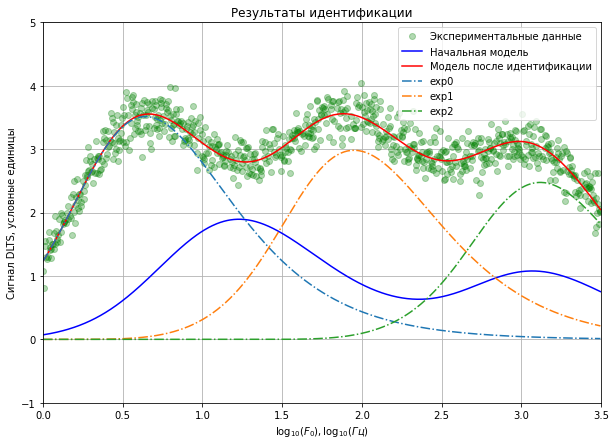

In [27]:
fit_results = grid_search.best_estimator_.fit_results_

fig, ax = plot_ident_res(X_train,
                         y_train, 
                         fit_results
                        )

plt.show()

In [28]:
mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test), squared=False)

0.21198018525922097